# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [84]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *
from itertools import groupby, chain

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [13]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
split = int(num_test/2)
test_data, test_labels = newsgroups_test.data[split:], newsgroups_test.target[split:]
dev_data, dev_labels = newsgroups_test.data[:split], newsgroups_test.target[:split]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('test label shape:', test_labels.shape)
print('dev label shape:', dev_labels.shape)
print('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

In [14]:
def P1(num_examples=5):

### STUDENT START ###
    for i in range(num_examples):
        print("Example", i+1)
        print("Label", newsgroups_train.target_names[train_labels[i]])
        print("Msg:", train_data[i])
### STUDENT END ###

P1()

Example 1
Label comp.graphics
Msg: Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
Example 2
Label talk.religion.misc
Msg: 

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
f

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [47]:
def P2():
    vectorizer = CountVectorizer()
    transformed = vectorizer.fit_transform(train_data)
    vectorizer_nms = vectorizer.get_feature_names()

    print("Shape is: ", transformed.shape)
    print("Non-zero: ",transformed.nnz)
    print("Avg. Non-zero per example: ",transformed.nnz/transformed.shape[0])

    print("a) Fraction of the matrix that is non-zero: ", transformed.nnz/(transformed.shape[0]*transformed.shape[1]))
    print("b) 0th feature and %d th feature: are %s and %s respectively" %(len(vectorizer_nms),vectorizer_nms[0],vectorizer_nms[len(vectorizer_nms)-1]))
    #work for C:
    fixed_vocabulary= ["atheism", "graphics", "space", "religion"]
    fixed_vectorizer = CountVectorizer(vocabulary=fixed_vocabulary)
    fixed_transformed = fixed_vectorizer.transform(train_data)
    #print("4-word vocabulary shape is: ", fixed_transformed.shape)
    print("c)4-word Avg. Non-zero per example: ",fixed_transformed.nnz/fixed_transformed.shape[0])
    n_vectorizer = CountVectorizer(analyzer='char_wb',ngram_range=(2,3))
    n_transformed = n_vectorizer.fit_transform(train_data)
    print("d)This yields a vocabulary of size %d (features)" %(n_transformed.shape[1]))
    #mindf threshold
    th = 10.0/len(train_data)
    th_vectorizer = CountVectorizer(min_df=th)
    th_transformed = th_vectorizer.fit_transform(train_data)
    print("e)This yields a vocabulary of size %d (features)" %(th_transformed.shape[1]))
    #Dev:
    dev_vectorizer = CountVectorizer()
    dev_transformed = dev_vectorizer.fit_transform(dev_data)
    dev_vectorizer_nms = dev_vectorizer.get_feature_names()
    missing = list(set(dev_vectorizer_nms) - set(vectorizer_nms))
    print("f)A total of %d words from the dev data are missing from the train vocabulary"%(len(missing)))
    
P2()



Shape is:  (2034, 26879)
Non-zero:  196700
Avg. Non-zero per example:  96.70599803343165
a) Fraction of the matrix that is non-zero:  0.0035978272269590263
b) 0th feature and 26879 th feature: are 00 and zyxel respectively
c)4-word Avg. Non-zero per example:  0.26843657817109146
d)This yields a vocabulary of size 28954 (features)
e)This yields a vocabulary of size 3064 (features)
f)A total of 4027 words from the dev data are missing from the train vocabulary


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

In [130]:
def P3(k_values,c_values,nb_alpha_values):
    vectorizer = CountVectorizer()
    vector_train_data = vectorizer.fit_transform(train_data)
    vector_dev_data = vectorizer.transform(dev_data)
    k_params = {'n_neighbors' : k_values}
    k_grid = GridSearchCV(KNeighborsClassifier(),k_params)
    k_grid.fit(vector_train_data,train_labels)
    best_k = k_grid.best_params_['n_neighbors']
    print("Best k is: ",best_k)
    knn = KNeighborsClassifier(n_neighbors=best_k)
    knn.fit(vector_train_data,train_labels)
    knn_prediction = knn.predict(vector_dev_data)
    print("Results with K = ", best_k)
    print("k=", best_k, "; accuracy:", np.mean(dev_labels == knn_prediction))
    print("F1 score is: ",metrics.f1_score(dev_labels,knn_prediction,average = 'weighted'))

    l_params = {'C' : c_values}
    l_grid = GridSearchCV(LogisticRegression(),l_params)
    l_grid.fit(vector_train_data,train_labels)
    best_c = l_grid.best_params_['C']
    print("Best C is: ",best_c)
    lrs = LogisticRegression(C=best_c)
    lrs = lrs.fit(vector_train_data, train_labels)
    l_predict = lrs.predict(vector_dev_data)
        # Compute accuracy on the test data.
    print('Accuracy of Logistic Regression with C = ' ,best_c)
    print(lrs.score(vector_dev_data,dev_labels))
    print("F1 score is: ",metrics.f1_score(dev_labels,l_predict,average = 'weighted'))

    for c in c_values:
        c_lrs = LogisticRegression(C=c)
        c_lrs = c_lrs.fit(vector_train_data, train_labels)
        for z  in range(len(newsgroups_train.target_names)):
            print('C = ',c,' Class: ',newsgroups_train.target_names[z])
            print("Sum of sqrd weight vals: ", np.sum(c_lrs.coef_[z]**2))

    #Multinomial Naive Bayes
    nb_params = {'alpha' : nb_alpha_values}
    nb_grid = GridSearchCV(MultinomialNB(),nb_params)
    nb_grid.fit(vector_train_data,train_labels)
    best_alpha = nb_grid.best_params_['alpha']
    print("Best alpha is: ",best_alpha)
    nby = MultinomialNB(alpha=best_alpha)
    nby.fit(vector_train_data, train_labels)
    print('Accuracy of Naive Bayes with best alpha is ', nby.score(vector_dev_data,dev_labels))
    nb_predict = nby.predict(vector_dev_data)
    print("F1 score is: ",metrics.f1_score(dev_labels,nb_predict,average = 'weighted'))
    
        
    
### STUDENT END ###
k_values = [1, 3, 5, 7,10,20,25,50,100,500]
C = [0.01,0.1,0.3,0.5,0.8,1.0,1.5,2.0,3.0,5.0,50]
alpha = [0.01,0.1,0.3,0.5,0.8,1.0,1.5,2.0,3.0,5.0]

P3(k_values,C,alpha)

Best k is:  100
Results with K =  100
k= 100 ; accuracy: 0.452662721893
F1 score is:  0.442240033922
Best C is:  0.5
Accuracy of Logistic Regression with C =  0.5
0.715976331361
F1 score is:  0.710072965653
C =  0.01  Class:  alt.atheism
Sum of sqrd weight vals:  2.54146332135
C =  0.01  Class:  comp.graphics
Sum of sqrd weight vals:  2.93970936836
C =  0.01  Class:  sci.space
Sum of sqrd weight vals:  2.86246910607
C =  0.01  Class:  talk.religion.misc
Sum of sqrd weight vals:  2.25002653626
C =  0.1  Class:  alt.atheism
Sum of sqrd weight vals:  27.1327065486
C =  0.1  Class:  comp.graphics
Sum of sqrd weight vals:  24.6567862219
C =  0.1  Class:  sci.space
Sum of sqrd weight vals:  27.4583009536
C =  0.1  Class:  talk.religion.misc
Sum of sqrd weight vals:  23.025587319
C =  0.3  Class:  alt.atheism
Sum of sqrd weight vals:  69.29002119
C =  0.3  Class:  comp.graphics
Sum of sqrd weight vals:  57.8710299455
C =  0.3  Class:  sci.space
Sum of sqrd weight vals:  67.9007192003
C =  0.3

a. Why doesn't nearest neighbors work well for this problem?
Curse of dimensionality! Nearest neighbors distance metrics (e.g. Euclidian distance) become effectively meaningless in such high dimensional spaces.

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

I think this might happen because some of the most influencial features (example words like "religion" and "church") are correlated and often appear together (giving a stronger signal). Naive Bayes will give both such words strong weights, so their influence is double-counted (independence!).  Whereas logistic regression might compensate by weighting them lower.

c. relationship between C and errors?
C effectively increases/decreases the weight of the error term relative to the regularization term. So the larger C the more it emphasizes model simplicity (higher srqrt weighted errors discurage complex models!)

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [125]:
def P4(bigram=False):
    vectorizer = CountVectorizer()
    if(bigram):
        vectorizer = CountVectorizer(analyzer='char_wb',ngram_range=(2,2))
    vector_train_data = vectorizer.fit_transform(train_data)
    vector_dev_data = vectorizer.transform(dev_data)
    lrs = LogisticRegression(C=0.5)
    lrs = lrs.fit(vector_train_data, train_labels)
### STUDENT START ###
    abso = False
    cols = []
    for z  in range(len(newsgroups_train.target_names)):
        if(abso):
            idx = np.absolute(lrs.coef_[z]).argsort()[-5:][::-1]
        else:
            idx = lrs.coef_[z].argsort()[-5:][::-1]
        cols = cols + list(idx)

    formatted = [np.array(vectorizer.get_feature_names())[cols]]
    for z  in range(len(newsgroups_train.target_names)):
        formatted.append(lrs.coef_[z][cols])
    f_array = np.array(formatted)
    #print(f_array.transpose())
    dpan = pd.DataFrame(data=f_array[1:,1:],columns = f_array[0,1:],index=newsgroups_train.target_names)             
    print(dpan.transpose())
    


### STUDENT END ###

P4()

                     alt.atheism         comp.graphics             sci.space  \
bobby         0.8234930562290871   -0.1913528957406948   -0.2863704891352188   
religion      0.7983165612859061   -0.5084283345439996   -0.6588413987735622   
atheism       0.7945009844521754  -0.35034466549199444  -0.36716821247229275   
deletion      0.7238305738656882  -0.24937209271856178  -0.27240728719081414   
graphics     -0.6408076259974551     1.626057198790417   -1.1028823519942297   
image       -0.46940375831853504     1.117040528803659   -0.6721757221194652   
file         -0.2752293533971663     1.059610902662762   -0.6826011277038864   
3d           -0.3033935766542485    0.9418761273614628   -0.5710465698005607   
computer     0.07140009208361534    0.8445141651705143   -0.5695028830220924   
space        -1.0611775540961002   -1.1160948457313284    1.8640508731097365   
orbit        -0.3502488824365674   -0.5595222743346125    1.0126893566915214   
nasa         -0.4654516441935484   -0.41

In [81]:
### STUDENT END ###
P4(bigram=True)

             alt.atheism          comp.graphics              sci.space  \
gi    0.2844520953376179    0.06455710512981706    -0.4718781195166055   
vo   0.26459013428786243   -0.03268262622112938   -0.20257323319924783   
rl   0.23565674568994477   -0.27845457801833273  -0.057742362222914026   
n'   0.23266990258088152    -0.3478687996656842   -0.15341690114781587   
3d  -0.11341831478837672     0.8995540327809471    -0.6262725671320882   
x   -0.05332073592344654     0.8417323718307889    -0.4151847310171006   
py  -0.07458805610842091     0.8008457287795284    -0.4296475291834116   
cs  -0.10708019780265682     0.7280548230174863   -0.30264273250767976   
 3  -0.18240258516489963     0.7036787138379076    -0.6176626743992102   
rb  -0.08795918675136437    -0.3634737520904218     0.9774496032596791   
nr  -0.04892607531960853     -0.127319227924291     0.7427132255086704   
ze  0.021122725193983533    -0.2537077084485332     0.7343230361000725   
eu  -0.06296356910947369  -0.009868459

Some of these words I wouldn't expect to have that strong a signal: FBI? Bobby? Blood? py/cs/3d

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [128]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
#replace non alpha numeric:
    #s = re.sub('[^\b\s\w0-9a-zA-Z/\'-\.\@&>]+','', s)
    #lowercase:
    s = s.lower()
    #replace sequence of numbers:
    grouped = groupby(s, str.isdigit)
    s = ''.join(chain.from_iterable('number_seq' if k else g for k,g in grouped))
    return s



def P5(preprocessor = empty_preprocessor):
    vectorizer = CountVectorizer(preprocessor=preprocessor)
    vector_train_data = vectorizer.fit_transform(train_data)
    vector_dev_data = vectorizer.transform(dev_data)
    lrs = LogisticRegression(C=0.5)
    lrs = lrs.fit(vector_train_data, train_labels)
    resu = lrs.predict(vector_dev_data)
    print("F1 score is: ",metrics.f1_score(dev_labels,resu,average = 'weighted'))
    print(len(vectorizer.get_feature_names()))

### STUDENT START ###


### STUDENT END ###

P5()
print("Refined preprocessor")
P5(preprocessor=better_preprocessor)

F1 score is:  0.706910918549
33291
Refined preprocessor
F1 score is:  0.708612289529
24761


I wasn't able to refine the F1 score much

(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

C:  0.001
Class alt.atheism as 1 and 26879 non-zero weights for L1 and L2 respectively
Class comp.graphics as 1 and 26879 non-zero weights for L1 and L2 respectively
Class sci.space as 2 and 26879 non-zero weights for L1 and L2 respectively
Class talk.religion.misc as 1 and 26879 non-zero weights for L1 and L2 respectively
F1 for 2 features:  0.322508590629
Accuracy:  0.372781065089
C:  0.01
Class alt.atheism as 9 and 26879 non-zero weights for L1 and L2 respectively
Class comp.graphics as 8 and 26879 non-zero weights for L1 and L2 respectively
Class sci.space as 8 and 26879 non-zero weights for L1 and L2 respectively
Class talk.religion.misc as 10 and 26879 non-zero weights for L1 and L2 respectively
F1 for 16 features:  0.467012012872
Accuracy:  0.48224852071
C:  0.1
Class alt.atheism as 107 and 26879 non-zero weights for L1 and L2 respectively
Class comp.graphics as 77 and 26879 non-zero weights for L1 and L2 respectively
Class sci.space as 81 and 26879 non-zero weights for L1 and L

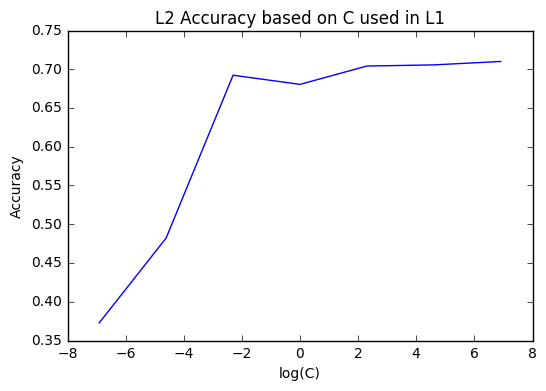

In [138]:
def P6(c_vec):
    np.random.seed(0)
    vectorizer = CountVectorizer()
    vector_train_data = vectorizer.fit_transform(train_data)
    vector_dev_data = vectorizer.transform(dev_data)
    accuracy = []
    features = []#can count the features dropped in L2 as well
    for c in c_vec:
        print("C: ", c)
        lr1 = LogisticRegression(C=c,penalty="l1")
        lr1.fit(vector_train_data,train_labels)
        lr2 = LogisticRegression(penalty="l2")
        lr2.fit(vector_train_data,train_labels)
        nzr = np.zeros(lr1.coef_[0].shape)
        for z in range(len(newsgroups_train.target_names)):
            l1_nzr = np.sum(np.absolute(lr1.coef_[z])>0.0)
            nzr = nzr + (np.absolute(lr1.coef_[z])>0.0)
            l2_nzr = np.sum(np.absolute(lr2.coef_[z])>0.0)
            print("Class %s as %d and %d non-zero weights for L1 and L2 respectively" 
                  %(newsgroups_train.target_names[z],l1_nzr,l2_nzr))
        #non zero cols/features
        nzr = (nzr>0.0)
        rdc_vector_train_data = vector_train_data[0:,nzr]
        rdc_vector_dev_data = vector_dev_data[0:,nzr]
        rdc_lr = LogisticRegression()
        rdc_lr = rdc_lr.fit(rdc_vector_train_data, train_labels)
        resu = rdc_lr.predict(rdc_vector_dev_data)
        print("F1 for %d features: " % (np.sum(nzr)), metrics.f1_score(dev_labels,resu,average = 'weighted'))
        acc = metrics.accuracy_score(dev_labels,resu)
        print("Accuracy: ",acc)
        accuracy = accuracy + [acc]
        features = features + [np.sum(nzr)]

    plt.plot(np.log(c_vec), np.array(accuracy))
    plt.title('L2 Accuracy based on C used in L1')
    plt.ylabel('Accuracy') 
    plt.xlabel('log(C)') 
    plt.show()

c_vec = [0.001,0.01, 0.1, 1.0,10,100,1000]

P6(c_vec)

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [158]:
def P7(C = 1.0):
    np.random.seed(0)
    vectorizer = TfidfVectorizer()
    vector_train_data = vectorizer.fit_transform(train_data)
    vector_dev_data = vectorizer.transform(dev_data)
    lr = LogisticRegression(C=C,penalty="l2")
    lr.fit(vector_train_data,train_labels)
    resu = lr.predict(vector_dev_data)
    print("F1 : ", metrics.f1_score(dev_labels,resu,average = 'weighted'))
    acc = metrics.accuracy_score(dev_labels,resu)
    print("Accuracy: ",acc)

    proba = lr.predict_proba(vector_dev_data)

    R = np.zeros(dev_labels.shape)
    for z in range(dev_labels.shape[0]):
        prob_cat = proba[z][dev_labels[z]]
        max_prob = np.max(proba[z])
        R[z] = max_prob/prob_cat
    #TOP 3
    idx = R.argsort()[-3:][::-1]
    print(R[idx])
    for i in range(len(idx)):
        print("Train document %d, R value of %f" %(idx[i],R[idx[i]]))
        print("Predicted category was %s with %f proba, right label is actually %s which got %f proba"
             %(newsgroups_train.target_names[resu[idx[i]]],np.max(proba[idx[i]]),
               newsgroups_train.target_names[dev_labels[idx[i]]],proba[idx[i]][dev_labels[idx[i]]]))
        #print(train_data[idx[i]:])        

    
P7(C = 100)

F1 :  0.759766242785
Accuracy:  0.763313609467
[ 929.35999884  325.00419858  287.30670358]
Train document 215, R value of 929.359999
Predicted category was comp.graphics with 0.993719 proba, right label is actually talk.religion.misc which got 0.001069 proba
Train document 665, R value of 325.004199
Predicted category was comp.graphics with 0.979745 proba, right label is actually talk.religion.misc which got 0.003015 proba
Train document 607, R value of 287.306704
Predicted category was talk.religion.misc with 0.695463 proba, right label is actually alt.atheism which got 0.002421 proba


Answer: how is this different from the CountVectorizer?
This assigns a weight to the tokens (words) based on the relative frequency within the entire training set.


What kinds of mistakes is the model making? 
I think the mistake is that some of the words that have strong correlation with the class(and are not that common) might be picked up as noise when training. One approach could be to use pairs of words instead (e.g. some of the same words will appear in texts related with atheism and religion but within different contexts!). 